In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from scipy import linalg
from tqdm import tqdm

In [2]:
# Global settings
np.random.seed(1234)
torch.manual_seed(1234)
DEVICE = torch.device("cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


##### **DATA PREPARATION**

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
mnist_train_full = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [4]:
train_size = 50000
val_size = 10000
train_ds, val_ds = random_split(mnist_train_full, [train_size, val_size], generator=torch.Generator().manual_seed(1234))

In [5]:
BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=False)
print(f"Training Samples: {len(train_ds)}, Validation Samples: {len(val_ds)}, Test Samples: {len(mnist_test)}")

Training Samples: 50000, Validation Samples: 10000, Test Samples: 10000


##### **TASK 1: VARIATIONAL AUTOENCODER (VAE)**

In [6]:
class VAE(nn.Module):
    """
        Variational Autoencoder with MLP architecture
        Architecture:
        - Encoder: 784 -> 512 -> 256 -> (mu: 16, log_sigma^2: 16)
        - Decoder: 16 -> 256 -> 512 -> 784
    """
    def __init__(self, input_dim=784, hidden1=512, hidden2=256, latent_dim=16):
        super(VAE, self).__init__()
        
        # Encoder Layers
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        
        # Latent Space
        self.fc_mu = nn.Linear(hidden2, latent_dim)
        self.fc_logvar = nn.Linear(hidden2, latent_dim)
        
        # Deccoder Layers
        self.fc3 = nn.Linear(latent_dim, hidden2)
        self.fc4 = nn.Linear(hidden2, hidden1)
        self.fc5 = nn.Linear(hidden1, input_dim)
        
    def encode(self, x):
        """
            Encode the input to latent space parameters
            Args:
                x: Input tensor of shape (batch_size, 784)
            Returns:
                mu: Mean of latent distribution
                logvar: Log variance of latent distribution
        """
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        """
            Reparameterization trick: z= mu + sigma * epsilon, epsilon ~ N(0,1)
            Args:
                mu: Mean of latent distribution
                logvar: Log variance of latent distribution
            Returns:
                z: Sampled latent vector
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + std * eps
        return z
    
    def decode(self, z):
        """
            Decode the latent vector to reconstructed image
            Args:
                z: Latent vector of shape (batch_size, latent_dim)
            Returns:
                reconstruction: Reconstructed image in [0, 1]
        """
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc4(h3))
        reconstruction = torch.sigmoid(self.fc5(h4))
        return reconstruction
    
    def forward(self, x):
        """
            Forward pass through the VAE
            Args:
                x: Input tensor of shape (batch_size, 784)
            Returns:
                reconstruction: Reconstructed image
                mu: Mean of latent distribution
                logvar: Log variance of latent distribution
        """
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstruction = self.decode(z)
        return reconstruction, mu, logvar

In [7]:
def vae_loss_fn(recon_x, x, mu, logvar):
    """
        VAE Loss = Reconstruction Loss (1) + KL Divergence (2)
        (1) -> Binary cross-entropy (summed over pixels, averaged over batch)
        (2) -> KL(N(mu, sigma^2) || N(0, 1)) = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        Args:
            recon_x: Reconstructed image
            x: Original image
            mu: Mean of latent distribution
            logvar: Log variance of latent distribution
        Returns:
            total_loss: Total VAE loss
            recon_loss: Reconstruction loss
            kl_loss: KL divergence loss
    """
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum') / x.size(0)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    total_loss = recon_loss + kl_loss
    return total_loss, recon_loss, kl_loss

In [8]:
vae_model = VAE().to(DEVICE)
print(vae_model)
total_params = sum(p.numel() for p in vae_model.parameters())
print(f"Total parameters in VAE model: {total_params}")
vae_optimizer = optim.Adam(vae_model.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=0)

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc_mu): Linear(in_features=256, out_features=16, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=784, bias=True)
)
Total parameters in VAE model: 1079600


In [9]:
def train_vae_epoch(model, train_loader, optimizer, epoch):
    """
        Train the VAE model for one epoch
    """
    model.train()
    train_loss = 0
    train_recon = 0
    train_kl = 0
    for batch_idx, (data, _) in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch} Training"):
        data = data.view(-1, 784).to(DEVICE)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, recon_loss, kl_loss = vae_loss_fn(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_recon += recon_loss.item()
        train_kl += kl_loss.item()
        
    n_batches = len(train_loader)
    avg_loss = train_loss / n_batches
    avg_recon = train_recon / n_batches
    avg_kl = train_kl / n_batches
    return avg_loss, avg_recon, avg_kl

In [10]:
def validate_vae(model, val_loader):
    """
        Validate the VAE model
    """
    model.eval()
    val_loss = 0
    val_recon = 0
    val_kl = 0
    
    with torch.no_grad():
        for data, _ in tqdm(val_loader, desc="Validation"):
            data = data.view(-1, 784).to(DEVICE)
            recon_batch, mu, logvar = model(data)
            loss, recon_loss, kl_loss = vae_loss_fn(recon_batch, data, mu, logvar)
            
            val_loss += loss.item()
            val_recon += recon_loss.item()
            val_kl += kl_loss.item()
    
    n_batches = len(val_loader)
    avg_loss = val_loss / n_batches
    avg_recon = val_recon / n_batches
    avg_kl = val_kl / n_batches
    return avg_loss, avg_recon, avg_kl

In [11]:
EPOCHS = 10
vae_history = {
    'train_loss': [],
    'train_recon': [],
    'train_kl': [],
    'val_loss': [],
    'val_recon': [],
    'val_kl': []
}
fixed_z = torch.randn(100, 16).to(DEVICE)

In [12]:
for epoch in range(1, EPOCHS + 1):
    train_loss, train_recon, train_kl = train_vae_epoch(vae_model, train_loader, vae_optimizer, epoch)
    val_loss, val_recon, val_kl = validate_vae(vae_model, val_loader)

    vae_history['train_loss'].append(train_loss)
    vae_history['train_recon'].append(train_recon)
    vae_history['train_kl'].append(train_kl)
    vae_history['val_loss'].append(val_loss)
    vae_history['val_recon'].append(val_recon)
    vae_history['val_kl'].append(val_kl)
    
    print(f"Epoch {epoch:2d}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} (Recon: {train_recon:.4f}, KL: {train_kl:.4f}) | "
          f"Val Loss: {val_loss:.4f} (Recon: {val_recon:.4f}, KL: {val_kl:.4f})")
    
    vae_model.eval()
    with torch.no_grad():
        samples = vae_model.decode(fixed_z).cpu().view(100, 1, 28, 28)
        
    fig, axes = plt.subplots(10, 10, figsize=(5, 5))
    for i in range(10):
        for j in range(10):
            axes[i, j].imshow(samples[i * 10 + j, 0], cmap='gray')
            axes[i, j].axis('off')
    plt.suptitle(f'VAE Generated Samples at Epoch {epoch}', y=0.995)
    plt.tight_layout()
    plt.savefig(f'vae_samples_epoch_{epoch}.png', dpi=100, bbox_inches='tight')
    plt.close()

Validation: 100%|██████████| 79/79 [00:01<00:00, 66.81it/s]


Epoch  1/10 | Train Loss: 183.5710 (Recon: 176.8367, KL: 6.7343) | Val Loss: 144.2318 (Recon: 131.6074, KL: 12.6244)


Validation: 100%|██████████| 79/79 [00:01<00:00, 47.44it/s]


Epoch  2/10 | Train Loss: 131.0461 (Recon: 116.3997, KL: 14.6465) | Val Loss: 122.8891 (Recon: 107.1146, KL: 15.7745)


Validation: 100%|██████████| 79/79 [00:00<00:00, 81.61it/s]


Epoch  3/10 | Train Loss: 118.2323 (Recon: 101.3249, KL: 16.9073) | Val Loss: 116.0781 (Recon: 98.5941, KL: 17.4840)


Validation: 100%|██████████| 79/79 [00:01<00:00, 49.46it/s]


Epoch  4/10 | Train Loss: 113.3904 (Recon: 95.6600, KL: 17.7304) | Val Loss: 112.5642 (Recon: 94.3229, KL: 18.2413)


Validation: 100%|██████████| 79/79 [00:02<00:00, 36.99it/s]


Epoch  5/10 | Train Loss: 110.7569 (Recon: 92.5805, KL: 18.1764) | Val Loss: 111.3503 (Recon: 92.5675, KL: 18.7828)


Validation: 100%|██████████| 79/79 [00:02<00:00, 32.48it/s]


Epoch  6/10 | Train Loss: 108.8830 (Recon: 90.4768, KL: 18.4062) | Val Loss: 108.7607 (Recon: 90.3152, KL: 18.4455)


Validation: 100%|██████████| 79/79 [00:03<00:00, 25.01it/s]


Epoch  7/10 | Train Loss: 107.5607 (Recon: 88.9334, KL: 18.6273) | Val Loss: 108.2399 (Recon: 89.6081, KL: 18.6318)


Validation: 100%|██████████| 79/79 [00:04<00:00, 17.87it/s]


Epoch  8/10 | Train Loss: 106.4176 (Recon: 87.6419, KL: 18.7756) | Val Loss: 107.1190 (Recon: 88.9051, KL: 18.2139)


Validation: 100%|██████████| 79/79 [00:01<00:00, 64.06it/s]


Epoch  9/10 | Train Loss: 105.5037 (Recon: 86.6226, KL: 18.8812) | Val Loss: 106.8205 (Recon: 88.1958, KL: 18.6247)


Validation: 100%|██████████| 79/79 [00:03<00:00, 24.52it/s]


Epoch 10/10 | Train Loss: 104.8304 (Recon: 85.7932, KL: 19.0372) | Val Loss: 105.8408 (Recon: 86.8193, KL: 19.0215)


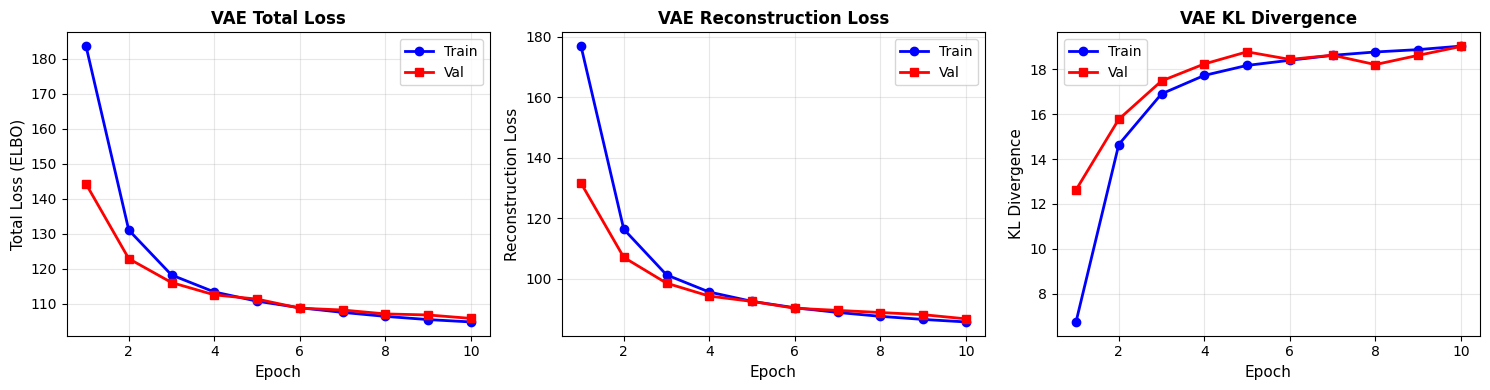

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Total loss (ELBO)
axes[0].plot(range(1, EPOCHS + 1), vae_history['train_loss'], 'b-o', label='Train', linewidth=2)
axes[0].plot(range(1, EPOCHS + 1), vae_history['val_loss'], 'r-s', label='Val', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Total Loss (ELBO)', fontsize=11)
axes[0].set_title('VAE Total Loss', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Reconstruction loss
axes[1].plot(range(1, EPOCHS + 1), vae_history['train_recon'], 'b-o', label='Train', linewidth=2)
axes[1].plot(range(1, EPOCHS + 1), vae_history['val_recon'], 'r-s', label='Val', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=11)
axes[1].set_ylabel('Reconstruction Loss', fontsize=11)
axes[1].set_title('VAE Reconstruction Loss', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# KL divergence
axes[2].plot(range(1, EPOCHS + 1), vae_history['train_kl'], 'b-o', label='Train', linewidth=2)
axes[2].plot(range(1, EPOCHS + 1), vae_history['val_kl'], 'r-s', label='Val', linewidth=2)
axes[2].set_xlabel('Epoch', fontsize=11)
axes[2].set_ylabel('KL Divergence', fontsize=11)
axes[2].set_title('VAE KL Divergence', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

##### **TASK 2: VAE RECONSTRUCTION AND GENERATION**

In [14]:
vae_model.eval()
val_data_iter = iter(val_loader)
val_images, _ = next(val_data_iter)
val_images = val_images[:5]
with torch.no_grad():
    val_flat = val_images.view(-1, 784).to(DEVICE)
    recon_images, _, _ = vae_model(val_flat)
    recon_images = recon_images.cpu().view(5, 1, 28, 28)

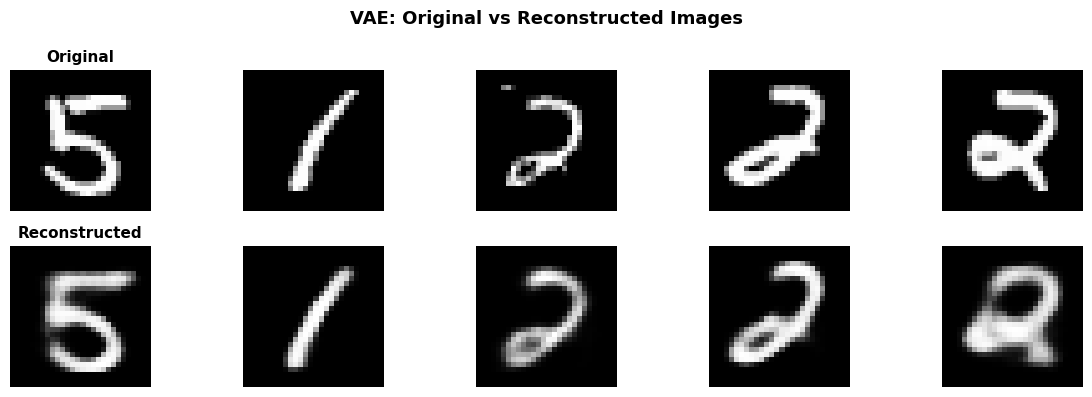

In [15]:
fig, axes = plt.subplots(2, 5, figsize=(12, 4))
for i in range(5):
    # Original Images
    axes[0, i].imshow(val_images[i, 0], cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Original', fontsize=11, fontweight='bold')
        
    # Reconstructed Images
    axes[1, i].imshow(recon_images[i, 0], cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Reconstructed', fontsize=11, fontweight='bold')

plt.suptitle('VAE: Original vs Reconstructed Images', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

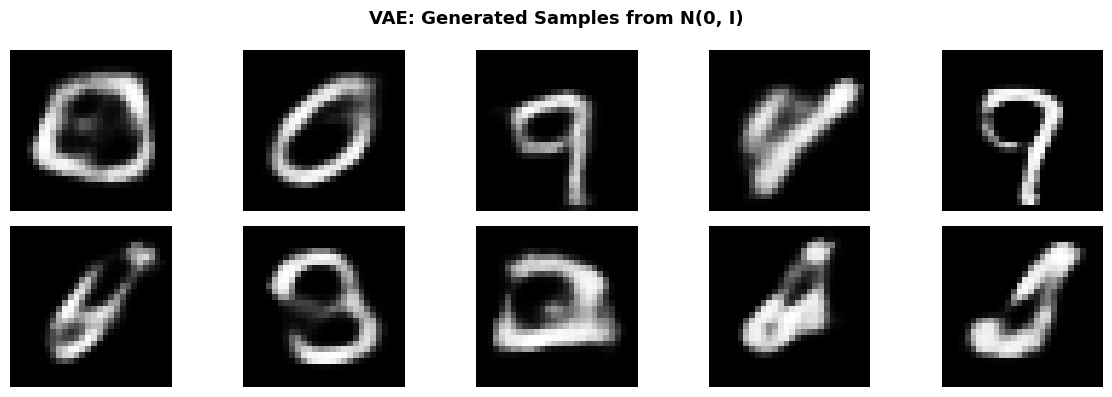

In [16]:
with torch.no_grad():
    z_sample = torch.randn(10, 16).to(DEVICE)
    generated = vae_model.decode(z_sample).cpu().view(10, 1, 28, 28)
    
fig, axes = plt.subplots(2, 5, figsize=(12, 4))
for i in range(2):
    for j in range(5):
        idx = i * 5 + j
        axes[i, j].imshow(generated[idx, 0], cmap='gray')
        axes[i, j].axis('off')
        
plt.suptitle('VAE: Generated Samples from N(0, I)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

##### **VAE IMAGE ANALYSIS**
| **Aspect**        | **Observation**                                                                 |
|--------------------|----------------------------------------------------------------------------------|
| **Reconstruction** | VAE produces smooth, slightly blurred reconstructions. The images are recognizable but lack sharp details. |
| **Diversity**       | Good diversity in generated digits, due to sampling from prior.                |


##### **TASK 3: GAN (MLP-BASED) - TRAINING**

In [17]:
class Generator(nn.Module):
    """
        GAN Generator: Maps latent vector z to image
        Architecture: 64 -> 256 -> 512 -> 784
        Activation: LeakyReLU(0.2) in hidden layers, Tanh in output layer
    """
    def __init__(self, latent_dim=64):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 784)
        
    def forward(self, z):
        """
            Generate image from latent vector
            Args:
                z: Latent vector of shape (batch_size, latent_dim)
            Returns:
                generated: Generated image in [-1, 1]
        """
        h1 = F.leaky_relu(self.fc1(z), 0.2)
        h2 = F.leaky_relu(self.fc2(h1), 0.2)
        img = torch.tanh(self.fc3(h2))
        return img

In [18]:
class Discriminator(nn.Module):
    """
        GAN Discriminator: Classifies image as real or fake
        Architecture: 784 -> 512 -> 256 -> 1
        Activation: LeakyReLU(0.2), Dropout(0.3) after hidden layers
        Output: Logit (no sigmoid)
    """
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, img):
        """
            Classify image as real or fake
            Args:
                img: Input image of shape (batch_size, 784)
            Returns:
                logit: Discriminator output logit
        """
        h1 = F.leaky_relu(self.fc1(img), 0.2)
        h1 = self.dropout(h1)
        h2 = F.leaky_relu(self.fc2(h1), 0.2)
        h2 = self.dropout(h2)
        logit = self.fc3(h2)
        return logit

In [19]:
latent_dim = 64
generator = Generator(latent_dim=latent_dim).to(DEVICE)
discriminator = Discriminator().to(DEVICE)
gen_params = sum(p.numel() for p in generator.parameters())
disc_params = sum(p.numel() for p in discriminator.parameters())
print(f"Generator:\n{generator}")
print(f"Total parameters in Generator: {gen_params}\n")
print(f"Discriminator:\n{discriminator}")
print(f"Total parameters in Discriminator: {disc_params}")

Generator:
Generator(
  (fc1): Linear(in_features=64, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=784, bias=True)
)
Total parameters in Generator: 550416

Discriminator:
Discriminator(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Total parameters in Discriminator: 533505


In [20]:
g_optimizer = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
criterion = nn.BCEWithLogitsLoss()
# For Label Smoothing
real_label, fake_label = 0.9, 0.0

In [24]:
def train_gan_epoch(generator, discriminator, train_loader, g_optimizer, d_optimizer, epoch):
    """
        Train the GAN model for one epoch
    """
    generator.train()
    discriminator.train()
    
    d_losses = []
    g_losses = []
    
    for batch_idx, (real_imgs, _) in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch} training"):
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.view(batch_size, -1).to(DEVICE)
        real_imgs = real_imgs * 2 - 1
        
        # ----- Train Discriminator -----
        d_optimizer.zero_grad()
        # Real images
        real_labels = torch.full((batch_size, 1), real_label, dtype=torch.float32, device=DEVICE)
        real_outputs = discriminator(real_imgs)
        d_loss_real = criterion(real_outputs, real_labels)
        # Fake images
        z = torch.randn(batch_size, latent_dim, device=DEVICE)
        fake_imgs = generator(z)
        fake_labels = torch.full((batch_size, 1), fake_label, dtype=torch.float32, device=DEVICE)
        fake_outputs = discriminator(fake_imgs.detach())
        d_loss_fake = criterion(fake_outputs, fake_labels)
        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()
        
        # ----- Train Generator -----
        g_optimizer.zero_grad()
        # Generate fake images and try to fool the discriminator
        z = torch.randn(batch_size, latent_dim, device=DEVICE)
        fake_imgs = generator(z)
        fake_outputs = discriminator(fake_imgs)
        real_labels = torch.ones(batch_size, 1, device=DEVICE)
        g_loss = criterion(fake_outputs, real_labels)
        g_loss.backward()
        g_optimizer.step()
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
    avg_d_loss = np.mean(d_losses)
    avg_g_loss = np.mean(g_losses)
    return avg_d_loss, avg_g_loss

In [25]:
gan_history = {
    'd_loss': [],
    'g_loss': []
}
fixed_noise = torch.randn(64, latent_dim, device=DEVICE)

In [26]:
for epoch in range(1, EPOCHS + 1):
    d_loss, g_loss = train_gan_epoch(generator, discriminator, train_loader, g_optimizer, d_optimizer, epoch)
    
    gan_history['d_loss'].append(d_loss)
    gan_history['g_loss'].append(g_loss)
    
    print(f"Epoch {epoch:2d}/{EPOCHS} | Discriminator Loss: {d_loss:.4f} | Generator Loss: {g_loss:.4f}")
    
    if epoch in [1, 5, 10]:
        generator.eval()
        with torch.no_grad():
            fake_images = generator(fixed_noise).cpu().view(64, 1, 28, 28)
            fake_images = (fake_images + 1) / 2
        
        fig, axes = plt.subplots(8, 8, figsize=(10, 10))
        for i in range(8):
            for j in range(8):
                axes[i, j].imshow(fake_images[i * 8 + j, 0], cmap='gray')
                axes[i, j].axis('off')
        plt.suptitle(f'GAN Generated Samples at Epoch {epoch}', y=0.995)
        plt.tight_layout()
        plt.savefig(f'gan_samples_epoch_{epoch}.png', dpi=100, bbox_inches='tight')
        plt.close()

Epoch 1 training: 100%|██████████| 391/391 [00:16<00:00, 23.11it/s]


Epoch  1/10 | Discriminator Loss: 0.9452 | Generator Loss: 1.9733


Epoch 2 training: 100%|██████████| 391/391 [00:17<00:00, 22.08it/s]


Epoch  2/10 | Discriminator Loss: 0.8712 | Generator Loss: 2.1213


Epoch 3 training: 100%|██████████| 391/391 [00:20<00:00, 19.48it/s]


Epoch  3/10 | Discriminator Loss: 0.8421 | Generator Loss: 2.2798


Epoch 4 training: 100%|██████████| 391/391 [00:19<00:00, 20.30it/s]


Epoch  4/10 | Discriminator Loss: 0.8423 | Generator Loss: 2.2575


Epoch 5 training: 100%|██████████| 391/391 [00:18<00:00, 20.81it/s]


Epoch  5/10 | Discriminator Loss: 0.8567 | Generator Loss: 2.1728


Epoch 6 training: 100%|██████████| 391/391 [00:18<00:00, 20.62it/s]


Epoch  6/10 | Discriminator Loss: 0.8428 | Generator Loss: 2.2279


Epoch 7 training: 100%|██████████| 391/391 [00:20<00:00, 18.90it/s]


Epoch  7/10 | Discriminator Loss: 0.8500 | Generator Loss: 2.2058


Epoch 8 training: 100%|██████████| 391/391 [00:18<00:00, 21.44it/s]


Epoch  8/10 | Discriminator Loss: 0.8839 | Generator Loss: 2.0988


Epoch 9 training: 100%|██████████| 391/391 [00:20<00:00, 19.18it/s]


Epoch  9/10 | Discriminator Loss: 0.8995 | Generator Loss: 1.9688


Epoch 10 training: 100%|██████████| 391/391 [00:19<00:00, 19.59it/s]


Epoch 10/10 | Discriminator Loss: 0.9050 | Generator Loss: 1.9646


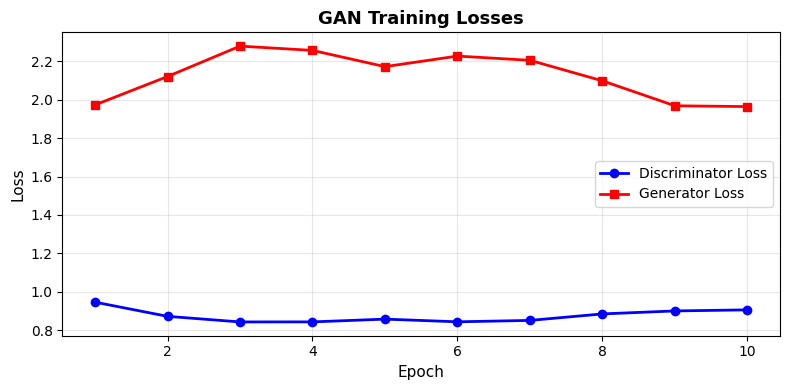

In [27]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, EPOCHS + 1), gan_history['d_loss'], 'b-o', label='Discriminator Loss', linewidth=2)
plt.plot(range(1, EPOCHS + 1), gan_history['g_loss'], 'r-s', label='Generator Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Loss', fontsize=11)
plt.title('GAN Training Losses', fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

##### **TASK 4: GAN - GENERATION** (COMPLETED ABOVE)

##### **GAN IMAGE ANALYSIS**
| **Aspect**        | **Observation**                                                                 |
|--------------------|----------------------------------------------------------------------------------|
| **Epoch 1**        | Generator produces noise-like patterns, learning basic structures               |
| **Epoch 5**        | Generator starts forming digit-like shapes, though still distorted              |
| **Epoch 10**       | More defined digit shapes emerge, but still lack the sharpness      |


**Mode Collapse**: Minimal evidence of mode collapse, though blurred the generated digits vary significantly.

##### **TASK 5: QUANTITATIVE COMPARISON**

In [28]:
class MNISTClassifier(nn.Module):
    """
        CNN Classifier for MNIST to compute IS/FID features.
        Architecture:
            - Conv2d(1->32, k=3, s=1, p=1) -> ReLU -> MaxPool(2)
            - Conv2d(32->64, k=3, s=1, p=1) -> ReLU -> MaxPool(2)
            - Flatten -> Linear(7*7*64 -> 128) -> ReLU -> Linear(128 -> 10)
    """
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(7 * 7 * 64, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x, return_features=False):
        """
            Forward pass with optional feature extraction
            Args:
                x: Input image tensor
                return_features: If True, return features from penultimate layer
            Returns:
                If return_features: (probabilities, features)
                Else: probabilities (softmax outputs)
        """
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 7 * 7 * 64)
        features = F.relu(self.fc1(x))
        logits = self.fc2(features)
        probs = F.softmax(logits, dim=1)
        if return_features:
            return probs, features
        else:
            return probs

In [29]:
classifier = MNISTClassifier().to(DEVICE)
classifier_optimizer = optim.Adam(classifier.parameters(), lr=1e-3)
classifier_criterion = nn.CrossEntropyLoss()
classifier_params = sum(p.numel() for p in classifier.parameters())
print(f"MNIST Classifier:\n{classifier}")
print(f"Total parameters: {classifier_params}")

MNIST Classifier:
MNISTClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Total parameters: 421642


In [30]:
mnist_full_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
classifier_loader = DataLoader(mnist_full_train, batch_size=128, shuffle=True)
classifier_epochs = 5

In [31]:
for epoch in range(1, classifier_epochs + 1):
    classifier.train()
    correct = 0
    total = 0
    
    for data, target in tqdm(classifier_loader, desc=f"Classifier Epoch {epoch} Training"):
        data, target = data.to(DEVICE), target.to(DEVICE)
        
        classifier_optimizer.zero_grad()
        outputs = classifier(data)
        loss = classifier_criterion(outputs, target)
        loss.backward()
        classifier_optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
    acc = 100 * correct / total
    print(f"Epoch {epoch:2d}/{classifier_epochs} | Training Accuracy: {acc:.2f}%")

Classifier Epoch 1 Training: 100%|██████████| 469/469 [00:37<00:00, 12.56it/s]


Epoch  1/5 | Training Accuracy: 81.89%


Classifier Epoch 2 Training: 100%|██████████| 469/469 [00:39<00:00, 12.02it/s]


Epoch  2/5 | Training Accuracy: 95.45%


Classifier Epoch 3 Training: 100%|██████████| 469/469 [00:41<00:00, 11.39it/s]


Epoch  3/5 | Training Accuracy: 98.06%


Classifier Epoch 4 Training: 100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


Epoch  4/5 | Training Accuracy: 98.45%


Classifier Epoch 5 Training: 100%|██████████| 469/469 [00:42<00:00, 11.12it/s]

Epoch  5/5 | Training Accuracy: 98.70%


In [32]:
# Freezing the classifier parameters
classifier.eval()
for param in classifier.parameters():
    param.requires_grad = False

In [33]:
# VAE Samples
vae_model.eval()
with torch.no_grad():
    z_vae = torch.randn(100, 16).to(DEVICE)
    vae_samples = vae_model.decode(z_vae).cpu().view(100, 1, 28, 28)
    
# GAN Samples
generator.eval()
with torch.no_grad():
    z_gan = torch.randn(100, latent_dim).to(DEVICE)
    gan_samples = generator(z_gan).cpu().view(100, 1, 28, 28)
    gan_samples = (gan_samples + 1) / 2

In [34]:
def compute_inception_score(samples, classifier, n_splits=10):
    """
        Compute the Inception Score
        IS = exp(E_x[KL(p(y|x) || p(y))])
        Args:
            samples: Generated samples tensor of shape (N, 1, 28, 28)
            classifier: Pretrained classifier model
            n_splits: Number of splits for IS computation
        Returns:
            mean_is: Mean Inception Score
            std_is: Standard Deviation of Inception Score
    """
    N = samples.size(0)
    with torch.no_grad():
        preds = classifier(samples.to(DEVICE)).cpu().numpy()
        
    split_scores = []
    chunk_size = N // n_splits
    for i in range(n_splits):
        start = i * chunk_size
        end = start + chunk_size if i != n_splits - 1 else N
        chunk_preds = preds[start:end]
        
        # p(y|x) for each sample
        py_x = chunk_preds
        # p(y) = mean over samples
        py = np.mean(py_x, axis=0, keepdims=True)
        # KL Divergence
        kl = py_x * (np.log(py_x + 1e-10) - np.log(py + 1e-10))
        kl = np.sum(kl, axis=1)
        
        mean_kl = np.mean(kl)
        split_scores.append(np.exp(mean_kl))
        
    mean_is = np.mean(split_scores)
    std_is = np.std(split_scores)
    return mean_is, std_is

In [35]:
is_vae_mean, is_vae_std = compute_inception_score(vae_samples, classifier)
is_gan_mean, is_gan_std = compute_inception_score(gan_samples, classifier)
print(f"VAE Inception Score: {is_vae_mean:.4f} ± {is_vae_std:.4f}")
print(f"GAN Inception Score: {is_gan_mean:.4f} ± {is_gan_std:.4f}")

VAE Inception Score: 4.9820 ± 0.5628
GAN Inception Score: 4.3732 ± 0.7814


In [36]:
def compute_fid(real_features, fake_features):
    """
        Compute the FID 
        FID = ||mu_r - mu_f||^2 + Tr(C_r + C_f - 2*(C_r*C_f)^(1/2))
        Args:
            real_features: Features from real images (N, D)
            fake_features: Features from generated images (N, D)
        Returns:
            fid_value: Computed FID score
    """
    mu_real = np.mean(real_features, axis=0)
    mu_fake = np.mean(fake_features, axis=0)
    
    sigma_real = np.cov(real_features, rowvar=False)
    sigma_fake = np.cov(fake_features, rowvar=False)
    
    diff = mu_real - mu_fake
    covmean, _ = linalg.sqrtm(sigma_real @ sigma_fake, disp=False)
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
        
    fid = diff @ diff + np.trace(sigma_real + sigma_fake - 2 * covmean)
    return fid

In [37]:
real_features_list = []
n_real = 0
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(DEVICE)
        _, features = classifier(data, return_features=True)
        real_features_list.append(features.cpu().numpy())
        n_real += data.size(0)
        if n_real >= 1000:
            break
real_features = np.concatenate(real_features_list, axis=0)[:1000]

In [38]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [39]:
with torch.no_grad():
    _, vae_features = classifier(vae_samples.to(DEVICE), return_features=True)
    vae_features = vae_features.cpu().numpy()
    
    _, gan_features = classifier(gan_samples.to(DEVICE), return_features=True)
    gan_features = gan_features.cpu().numpy()

In [40]:
fid_vae = compute_fid(real_features, vae_features)
fid_gan = compute_fid(real_features, gan_features)
print(f"VAE FID: {fid_vae:.4f}")
print(f"GAN FID: {fid_gan:.4f}")

VAE FID: 973.0690
GAN FID: 1245.5567


In [41]:
print("\n{:<15} {:<20} {:<20}".format("Model", "Inception Score ↑", "FID ↓"))
print("-" * 55)
print("{:<15} {:.4f} ± {:.4f}        {:.4f}".format("VAE", is_vae_mean, is_vae_std, fid_vae))
print("{:<15} {:.4f} ± {:.4f}        {:.4f}".format("GAN", is_gan_mean, is_gan_std, fid_gan))
print("-" * 55)
print("↑ Higher is better | ↓ Lower is better")


Model           Inception Score ↑    FID ↓               
-------------------------------------------------------
VAE             4.9820 ± 0.5628        973.0690
GAN             4.3732 ± 0.7814        1245.5567
-------------------------------------------------------
↑ Higher is better | ↓ Lower is better


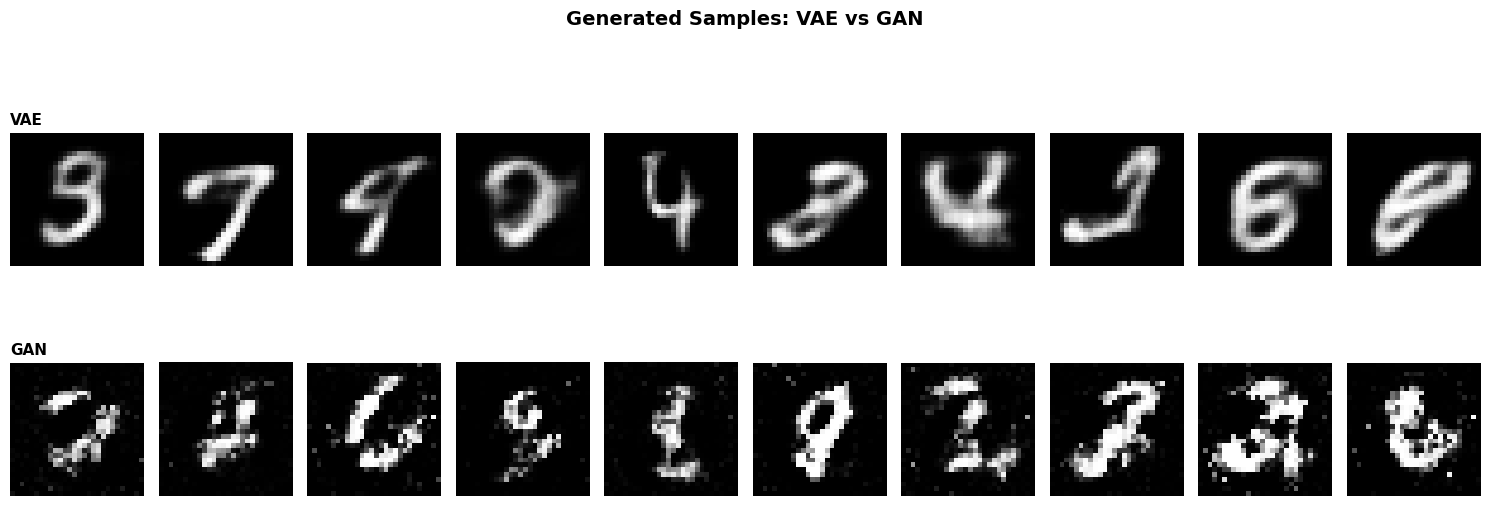

In [42]:
# For Visual Comparison
fig = plt.figure(figsize=(15, 6))
# VAE Samples
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    ax.imshow(vae_samples[i, 0], cmap='gray')
    ax.axis('off')
    if i == 0:
        ax.set_title('VAE', fontsize=11, fontweight='bold', loc='left')
        
# GAN Samples
for i in range(10):
    ax = plt.subplot(2, 10, i + 11)
    ax.imshow(gan_samples[i, 0], cmap='gray')
    ax.axis('off')
    if i == 0:
        ax.set_title('GAN', fontsize=11, fontweight='bold', loc='left')
        
plt.suptitle('Generated Samples: VAE vs GAN', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()